# GPU info

In [1]:
!nvidia-smi

Fri Feb  7 22:30:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.81                 Driver Version: 560.81         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 960M      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A    0C    P0             N/A /  200W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import

In [269]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch import Tensor
from torch import optim

import torchvision
from torchvision import transforms as T
from torchvision.utils import make_grid, save_image
from torchvision import models

from PIL import Image

from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import re
from os import listdir

from tqdm import tqdm
from torchmetrics import Accuracy

In [3]:
torch.__version__, torchvision.__version__

('2.5.1+cu124', '0.20.1+cu124')

# Device

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Utils, functions, and classes

In [16]:
def num_params(model, trainable=False):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    print(f"The number of parameters: {num:,}")

In [17]:
class Averaging():
    def __init__(self):
        self.sum = 0.
        self.counter = 0

    def __call__(self, val: float) -> float:
        self.sum += val
        self.counter += 1

        return self.sum / self.counter

    def reset(self):
        self.sum = 0.
        self.counter = 0

In [18]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, avg_fn, acc_fn, ep, device):
    model.train()
    
    acc_fn.reset()
    avg_fn.reset()
    
    with tqdm(dataloader, desc=f"Epoch {ep}", unit=" batch") as trange:
       for x_batch, y_batch in trange:
           x_batch, y_batch = x_batch.to(device), y_batch.to(device)

           # Forward
           yp = model(x_batch)
           loss = loss_fn(yp, y_batch)
           
           # Backward
           loss.backward()
           optimizer.step()
           optimizer.zero_grad()

           loss_avg = avg_fn(loss.item())
           acc_fn(yp, y_batch)
           acc_avg = acc_fn.compute().item()

           trange.set_postfix(loss=loss_avg, acc=100*acc_avg)
    
    return model, loss_avg, acc_avg

In [19]:
def validate_one_epoch(model, dataloader, loss_fn, avg_fn, acc_fn, device):
    model.eval()
    
    acc_fn.reset()
    avg_fn.reset()

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)
            
            loss_avg = avg_fn(loss.item())
            acc_fn(yp, y_batch)
            acc_avg = acc_fn.compute().item()
        
    return loss_avg, acc_avg

In [20]:
def plot_loss_acc(train_loss, train_acc, valid_loss, valid_acc):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axs[0].plot(train_loss, c='b', label="Train Loss")
    axs[0].plot(valid_loss, c='r', label="Valid Loss")
    
    axs[1].plot(train_acc, c='b', label="Valid Acc")
    axs[1].plot(valid_acc, c='r', label="Valid Acc")

    axs[0].set_ylabel("Cross Entropy Loss")
    axs[0].set_title("Learning Curve")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy Curve")
    
    for ax in axs:
        ax.set_xlabel("Epoch")
        ax.legend()
        ax.grid()

# Inits

In [353]:
img_size = (224, 224)
trans_mean, trans_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
valid_set_size = 0.2
train_batch_size = 128
valid_batch_size = 256
subset_size = 0.3
num_cls = 120

lr = 0.01
epochs = 10

loss_fn = nn.CrossEntropyLoss()
avg_fn = Averaging()
acc_fn = Accuracy(task="multiclass", num_classes=num_cls).to(device)

# Preprocessing <a href="http://vision.stanford.edu/aditya86/ImageNetDogs/">Download Dataset</a>

## Transforms for images

In [6]:
train_transforms = T.Compose([T.RandAugment(), T.Resize(img_size), T.ToTensor(), T.Normalize(mean=trans_mean, std=trans_std)])
test_transforms = T.Compose([T.Resize(img_size), T.ToTensor(), T.Normalize(mean=trans_mean, std=trans_std)])

## Custom dataset

In [305]:
class StanfordDogsDataset(Dataset):
    def __init__(self, transforms, phase="train", root_path=r"./dogs_dataset"):
        self.transforms = transforms
        
        images_root_path = f"{root_path}/images/"
        
        mat_file = loadmat(root_path+f"/{phase}_list")

        self.file_list = mat_file["file_list"]
        self.labels = torch.LongTensor(mat_file["labels"]).squeeze() - 1
        
        self.images = [(images_root_path+f[0][0], l.item()) for f, l in zip(self.file_list, self.labels)]

        # unique samples
        self.sample_ls = []
        pattern = r'-(\w+)'
        for sample in listdir("./dogs_dataset/Annotation"):
            match = re.search(pattern, sample.lower())
            if match:
                self.sample_ls.append(match.group(1))

    def __getitem__(self, item_idx: int):
        img_path, label = self.images[item_idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transforms(img)
        
        return img, label

    def get_sample_name(self, label: int):
        return self.sample_ls[label]
        
    def __len__(self):
        return len(self.images)

## Read datasets

In [8]:
main_train_set = StanfordDogsDataset(train_transforms)
test_set = StanfordDogsDataset(test_transforms, "test")

## Split train and valid sets

In [9]:
train_set, valid_set = random_split(main_train_set, lengths=[1 - valid_set_size, valid_set_size])

## Make dataloader

In [10]:
train_loader = DataLoader(train_set, train_batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, valid_batch_size)
test_loader = DataLoader(test_set, valid_batch_size)

## Visialize a batch

In [11]:
x, y = next(iter(train_loader))

x.shape, y

(torch.Size([128, 3, 224, 224]),
 tensor([ 18,  17,  60, 105, 110,  35, 100,   5,  88,  42,  87,  74,  53,  39,
          79,  74,  29,  57,  58,  19,  53,  38,  26,  53, 114,  34,  55, 112,
          98,  86,  35,  90,  81, 101,   2,  81, 110, 112,  29,  53,  56,  88,
           7,  83,  17,   5,  96,  53,  31,  72,  81,  61,  91,  58, 101,  73,
          97, 115,  31,  88,  89,  73,  11,  49,  26,  52,  55,  56,  61,  59,
          26,  22, 102,  68,  67,  45,  78,  29,  50,  25, 105, 107,  72,  99,
          99,  85,  27,  74, 103,  60,  98,  82,   1,  88, 115, 115,  16,  12,
          95,  42,   2,  12,  68,  23, 103,  64,  66,  58, 100,   9, 114,  15,
           4,  37,  23, 114, 106,  42, 109,  91,  71,  73,  98,  90,  86,  90,
          74,  83]))

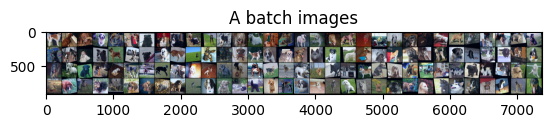

In [12]:
img_grid = make_grid(x, nrow=32, padding=6, normalize=True).permute(1, 2, 0)

plt.title("A batch images")
plt.imshow(img_grid);

# Model

In [14]:
class CustomResNet(nn.Module):
    def __init__(self, model=models.resnet50, pretrained_weights=models.ResNet50_Weights.IMAGENET1K_V2, num_cls:int=120):
        super(CustomResNet, self).__init__()

        self.model = model(weights=pretrained_weights)
        in_features = self.model.fc.in_features
        self.num_cls = num_cls

        # Remove the last two layers (AvgPool and FC) to just use the output Feature Map of the Body
        self.model = nn.Sequential(*list(self.model.children())[:-2])

        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(in_features=in_features, out_features=self.num_cls)

        # Freeze the Body of the model for fine-tunning (Just train the output layer)
        self.model.requires_grad_(False)
    
    def forward(self, x: Tensor):
        y = self.model(x)
        y = self.avg_pool(y)
        y = self.fc(y.flatten(1))
        
        return y

# Check forward and backward

## Create a subset

### Mini train set

In [19]:
_, train_subset = random_split(train_set, lengths=[1 - subset_size, subset_size])
mini_train_loader = DataLoader(train_subset, train_batch_size, shuffle=True)

### Mini valid set

In [20]:
_, valid_subset = random_split(valid_set, lengths=[1 - subset_size, subset_size])
mini_valid_loader = DataLoader(valid_subset, valid_batch_size)

## Check forward path

In [21]:
model = CustomResNet().to(device)
num_params(model)

with torch.no_grad():
    yp = model(x.to(device))
    loss = loss_fn(yp, y.to(device))

torch.cuda.empty_cache()

loss.item()

The number of parameters: 245,880


4.802856922149658

## Check backward path

In [22]:
model = CustomResNet().to(device)
optimizer = optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)

for ep in range(3):
    model, _, _ = train_one_epoch(model, mini_train_loader, optimizer, loss_fn, avg_fn, acc_fn, ep, device)
    valid_loss_val, valid_acc_val = validate_one_epoch(model, mini_valid_loader, loss_fn, avg_fn, acc_fn, device)
    
    print(f"Valid acc: {100*valid_acc_val:.3}, loss: {valid_loss_val:.3}")

torch.cuda.empty_cache()

Epoch 0: 100%|████████████████████████████████████████████████| 23/23 [01:03<00:00,  2.74s/ batch, acc=11.7, loss=4.64]


Valid acc: 41.1, loss: 4.36


Epoch 1: 100%|███████████████████████████████████████████████████| 23/23 [01:03<00:00,  2.78s/ batch, acc=59.2, loss=4]


Valid acc: 59.9, loss: 3.74


Epoch 2: 100%|████████████████████████████████████████████████| 23/23 [01:03<00:00,  2.78s/ batch, acc=71.5, loss=3.33]


Valid acc: 66.0, loss: 3.16


# Find efficient hyper-parameters

In [23]:
# for lr in [0.001, 0.01, 0.02]:
#     model = CustomResNet().to(device)
#     optimizer = optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)

#     print(f"\nlr: {lr}")
#     for ep in range(3):
#         model, _, _ = train_one_epoch(model, train_loader, optimizer, loss_fn, avg_fn, acc_fn, ep, device)

# torch.cuda.empty_cache()

# Full train

In [24]:
model = CustomResNet().to(device)
optimizer = optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)

num_params(model)

The number of parameters: 245,880


In [25]:
train_loss_hist, valid_loss_hist, train_acc_hist, valid_acc_hist = [], [], [], []

In [26]:
for ep in range(epochs):
    model, train_loss_val, train_acc_val = train_one_epoch(model, train_loader, optimizer, loss_fn, avg_fn, acc_fn, ep, device)
    valid_loss_val, valid_acc_val = validate_one_epoch(model, valid_loader, loss_fn, avg_fn, acc_fn, device)

    train_loss_hist.append(train_loss_val)
    valid_loss_hist.append(valid_loss_val)
    train_acc_hist.append(train_acc_val)
    valid_acc_hist.append(valid_acc_val)

    print(f"Valid acc: {100*valid_acc_val:.3}, loss: {valid_loss_val:.3}")

torch.cuda.empty_cache()

Epoch 0: 100%|████████████████████████████████████████████████| 75/75 [03:22<00:00,  2.69s/ batch, acc=48.2, loss=3.98]


Valid acc: 73.2, loss: 3.06


Epoch 1: 100%|████████████████████████████████████████████████| 75/75 [03:16<00:00,  2.62s/ batch, acc=79.9, loss=2.26]


Valid acc: 79.3, loss: 1.78


Epoch 2: 100%|████████████████████████████████████████████████| 75/75 [03:18<00:00,  2.64s/ batch, acc=84.2, loss=1.36]


Valid acc: 81.2, loss: 1.2


Epoch 3: 100%|███████████████████████████████████████████████| 75/75 [03:17<00:00,  2.64s/ batch, acc=85.8, loss=0.987]


Valid acc: 81.9, loss: 0.98


Epoch 4: 100%|███████████████████████████████████████████████| 75/75 [03:16<00:00,  2.62s/ batch, acc=87.1, loss=0.801]


Valid acc: 83.2, loss: 0.842


Epoch 5: 100%|████████████████████████████████████████████████| 75/75 [03:17<00:00,  2.63s/ batch, acc=87.3, loss=0.71]


Valid acc: 83.4, loss: 0.775


Epoch 6: 100%|███████████████████████████████████████████████| 75/75 [03:17<00:00,  2.64s/ batch, acc=88.2, loss=0.632]


Valid acc: 82.8, loss: 0.743


Epoch 7: 100%|███████████████████████████████████████████████| 75/75 [03:17<00:00,  2.63s/ batch, acc=88.4, loss=0.589]


Valid acc: 83.3, loss: 0.704


Epoch 8: 100%|███████████████████████████████████████████████| 75/75 [03:15<00:00,  2.60s/ batch, acc=88.9, loss=0.552]


Valid acc: 83.7, loss: 0.659


Epoch 9: 100%|███████████████████████████████████████████████| 75/75 [03:14<00:00,  2.59s/ batch, acc=89.6, loss=0.512]


Valid acc: 83.7, loss: 0.644


# Plot loss and accuracy

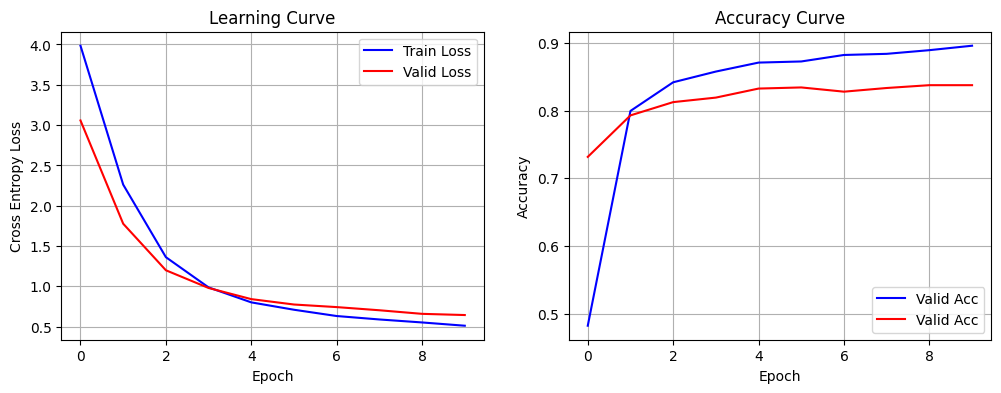

In [27]:
plot_loss_acc(train_loss_hist, train_acc_hist, valid_loss_hist, valid_acc_hist)

## Save the trained model

In [51]:
print(f"{100*valid_acc_hist[-1]:.4}")

83.75


In [54]:
torch.save(model, f"final_model_{100*valid_acc_hist[-1]:.4}_accuracy.pt")

# Final test and report

## Load the trained model

In [343]:
final_model = torch.load("./final_model_83.75_accuracy.pt", weights_only=False).to(device)

## Run and report the model on Testset

In [317]:
loss, acc = validate_one_epoch(final_model, test_loader, loss_fn, avg_fn, acc_fn, device)

torch.cuda.empty_cache()

In [332]:
print(f"Testset report on ({len(test_set)}) samples:\n\tCros Entropy Loss: {loss:.4}\n\tAccuracy: {100*acc:.4}")

Testset report on (8580) samples:
	Cros Entropy Loss: 0.478
	Accuracy: 88.68


## Test your desiered image

In [351]:
test_img = Image.open(r"./self_test_dogs_images/rottweiler-1-1.jpg")

res = final_model(test_transforms(test_img).unsqueeze(0).to(device))
soft = torch.softmax(res, dim=1)
res = torch.argmax(soft).item()
dataset_obj = StanfordDogsDataset(test_transforms)
res = dataset_obj.get_sample_name(res)

print(f"The kind of dog is: {res}")

The kind of dog is: appenzeller
